# Segmentation

In [4]:
import JupyterNotebooksLib as slicernb
import slicer, vtk

# Set image viewer size to 50% (fill half of a cell)
slicernb.AppWindow.setWindowSize(scale=0.5)
# Hide patient information from slice view
slicernb.showSliceViewAnnotations(False)

# Example of installing an extension:
# slicernb.installExtensions(["SegmentEditorExtraEffects"])

## Automatic tumor segmentation from seeds

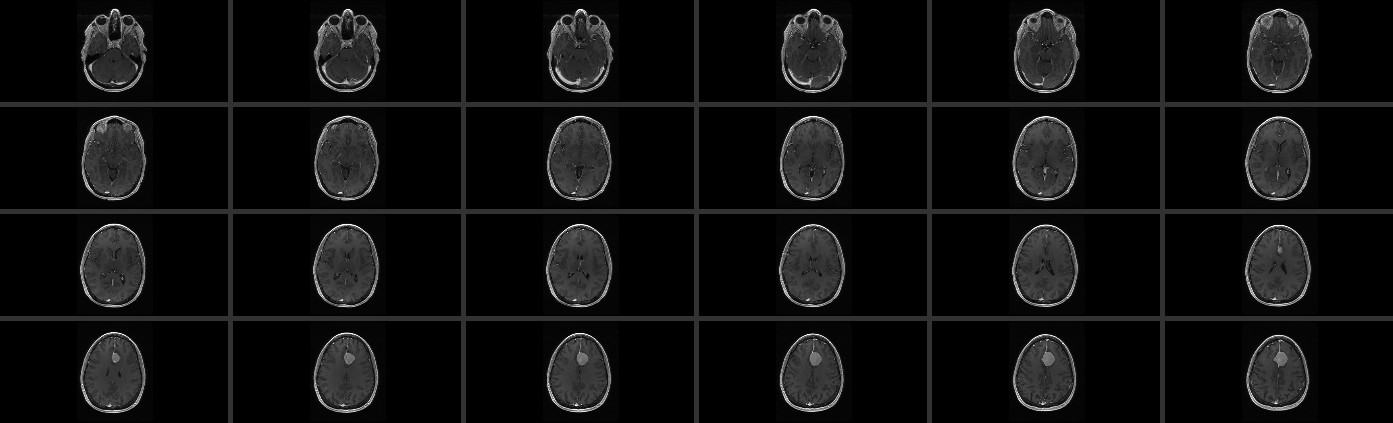

In [5]:
# Clear scene
slicer.mrmlScene.Clear(False)

# Load from local file
volume = slicer.util.loadVolume('data/MRBrainTumor1.nrrd')

# Lightbox view
slicernb.ViewLightboxDisplay("Red", rangeShrink=[45,50])

self.extentGrowthRatio = 0.1
masterImageExtent = (0, 255, 0, 255, 0, 111)
labelsEffectiveExtent = (85, 182, 48, 152, 44, 108)
labelsExpandedExtent = [76, 191, 38, 162, 38, 111]
Grow-cut operation on volume of 116x125x74 voxels was completed in 0.6 seconds.


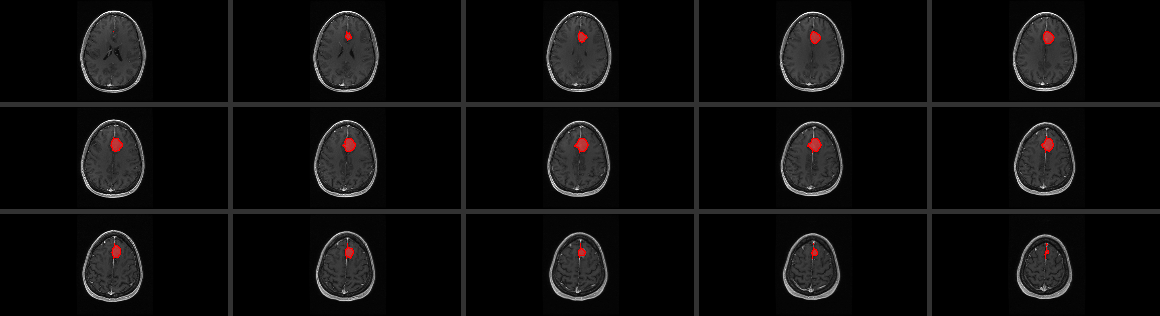

In [6]:
# Create segmentation
segmentationNode = slicer.vtkMRMLSegmentationNode()
slicer.mrmlScene.AddNode(segmentationNode)
segmentationNode.CreateDefaultDisplayNodes() # only needed for display
segmentationNode.SetReferenceImageGeometryParameterFromVolumeNode(volume)

# Create seed segment inside tumor
tumorSeed = vtk.vtkSphereSource()
tumorSeed.SetCenter(-6, 30, 28)
tumorSeed.SetRadius(10)
tumorSeed.Update()
tumorSegmentId = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(tumorSeed.GetOutput(), "Tumor", [1.0,0.0,0.0])

# Create seed segment outside tumor
backgroundSeedPositions = [[0,65,32], [1, -14, 30], [0, 28, -7], [0,30,64], [31, 33, 27], [-42, 30, 27]]
append = vtk.vtkAppendPolyData()
for backgroundSeedPosition in backgroundSeedPositions:
  backgroundSeed = vtk.vtkSphereSource()
  backgroundSeed.SetCenter(backgroundSeedPosition)
  backgroundSeed.SetRadius(10)
  backgroundSeed.Update()
  append.AddInputData(backgroundSeed.GetOutput())

append.Update()
backgroundSegmentId = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(append.GetOutput(), "Background", [0.0,1.0,0.0])

# Run filter
################################################

# Create segment editor to get access to effects
segmentEditorWidget = slicer.qMRMLSegmentEditorWidget()
# To show segment editor widget (useful for debugging): segmentEditorWidget.show()
segmentEditorWidget.setMRMLScene(slicer.mrmlScene)
segmentEditorNode = slicer.vtkMRMLSegmentEditorNode()
slicer.mrmlScene.AddNode(segmentEditorNode)
segmentEditorWidget.setMRMLSegmentEditorNode(segmentEditorNode)
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volume)

# Run segmentation
segmentEditorWidget.setActiveEffectByName("Grow from seeds")
effect = segmentEditorWidget.activeEffect()
# You can change parameters by calling: effect.setParameter("MyParameterName", someValue)
# Most effect don't have onPreview, you can just call onApply
effect.self().onPreview()
effect.self().onApply()

# Clean up and show results
################################################

# Clean up
slicer.mrmlScene.RemoveNode(segmentEditorNode)

# Make segmentation results nicely visible in 3D
segmentationDisplayNode = segmentationNode.GetDisplayNode()
segmentationDisplayNode.SetSegmentVisibility(backgroundSegmentId, False)

# 
segmentCenterRAS = segmentationNode.GetSegmentCenterRAS(tumorSegmentId)
slicernb.ViewLightboxDisplay(rows=3, columns=5, positionRange=[segmentCenterRAS[2]-25, segmentCenterRAS[2]+10])

## Manual segmentation

IntProgress(value=0)

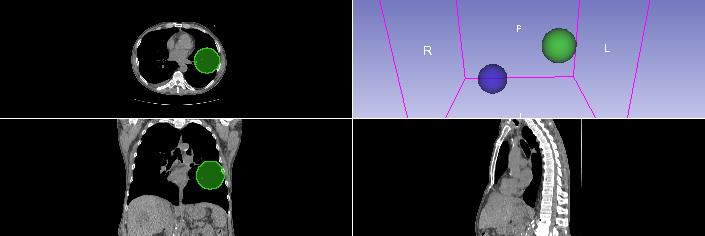

In [8]:
# Download a volume from a URL
slicer.mrmlScene.Clear()
volume = slicernb.downloadFromURL(
  'https://github.com/Slicer/SlicerTestingData/releases/download/SHA256/4507b664690840abb6cb9af2d919377ffc4ef75b167cb6fd0f747befdb12e38e',
  'CTChest.nrrd', "CT")

app = slicernb.AppWindow(contents="viewers", windowScale=0.3)

slicer.util.selectModule("SegmentEditor")
segmentEditorWidget = slicer.modules.segmenteditor.widgetRepresentation().self().editor
segmentEditorNode = segmentEditorWidget.mrmlSegmentEditorNode()
segmentationNode=slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volume)

# Add a sphere-shaped segment
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(-100, -30, -170)
sphereSource.SetRadius(45)
sphereSource.SetThetaResolution(20)
sphereSource.Update()
sphere1SegmentID = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(sphereSource.GetOutput(), "sphere 1", [0.2,0.8,0.1])

# Add a sphere-shaped segment
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(64, 30, -230)
sphereSource.SetRadius(35)
sphereSource.SetThetaResolution(20)
sphereSource.Update()
sphere2SegmentID = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(sphereSource.GetOutput(), "sphere 2", [0.2,0.1,0.8])

# Show results
segmentationNode.GetSegmentation().SetConversionParameter('Smoothing factor','0.0') # disable 3D smoothing
segmentationNode.CreateClosedSurfaceRepresentation() # show segmentation in 3D
segmentationNode.GetDisplayNode().SetOpacity3D(0.5)
volume.GetDisplayNode().AutoWindowLevelOff()
volume.GetDisplayNode().SetWindowLevel(420,30)
slicernb.ViewDisplay("FourUp")

# Edit segments in 3D using scissors

In [9]:
segmentEditorNode.SetSelectedSegmentID(sphere1SegmentID)

slicernb.setViewLayout("OneUp3D")
app.setWindowSize(scale=0.3)
app.setContents("viewers")

live3dSeg = slicernb.ViewInteractiveWidget('1')
live3dSeg.trackMouseMove = True
display(live3dSeg)

def cut(button, segmentId):
    if segmentId:
        segmentEditorNode.SetSelectedSegmentID(segmentId)
        segmentEditorWidget.setActiveEffectByName("Scissors")
    else:
        segmentEditorWidget.setActiveEffectByName("")

from ipywidgets import Button, HBox
cutBlueButton = Button(description='Cut green')
cutBlueButton.on_click(lambda button, segmentId=sphere1SegmentID: cut(button, segmentId))
cutGreenButton = Button(description='Cut blue')
cutGreenButton.on_click(lambda button, segmentId=sphere2SegmentID: cut(button, segmentId))
rotateButton = Button(description='Rotate')
rotateButton.on_click(lambda button, segmentId="": cut(button, segmentId))
HBox([cutBlueButton, cutGreenButton, rotateButton])    

ViewInteractiveWidget(height=202, width=576)

In [10]:
# Only available if jupyter desktop server is configured.
# "404 : Not Found" error is displayed if Jupyter desktop server is not configured,
# in that case, switch to the application window if Slicer is running locally.
display(app)
app.setWindowSize(scale=1.0)
slicernb.setViewLayout("FourUp")

# app.setContents("full")  # Run this to show full application GUI

In [11]:
# Edit sphere1 segment using draw effect
segmentEditorNode.SetSelectedSegmentID(sphere1SegmentID)
segmentEditorWidget.setActiveEffectByName("Draw")

liveRedSliceSeg = slicernb.ViewInteractiveWidget('R')
liveRedSliceSeg.trackMouseMove = True
liveRedSliceSeg.setQuickRenderDelay(0.5) # expect slow updates
display(liveRedSliceSeg)

ViewInteractiveWidget(height=457, width=960)

In [12]:
# Show initial slices
before = slicernb.View3DWidget()

# Fill between slices
segmentationNode.GetDisplayNode().SetSegmentVisibility(sphere2SegmentID, False)
segmentEditorWidget.setActiveEffectByName("Fill between slices")
effect = segmentEditorWidget.activeEffect()
effect.self().onPreview()
effect.self().onApply()
segmentationNode.GetDisplayNode().SetSegmentVisibility(sphere2SegmentID, True)

# Show complete segmentation
after = slicernb.View3DWidget()

from ipywidgets import HBox
before.width="45%"
after.width="45%"
HBox([before, after])

self.extentGrowthRatio = 0.1
masterImageExtent = (0, 511, 0, 511, 0, 138)
labelsEffectiveExtent = (330, 443, 208, 322, 54, 84)
labelsExpandedExtent = [319, 454, 197, 333, 51, 87]


In [13]:
# Enable 3D display smoothing
segmentationNode.GetSegmentation().SetConversionParameter('Smoothing factor','0.9') # enable 3D smoothing
segmentationNode.RemoveClosedSurfaceRepresentation()
segmentationNode.CreateClosedSurfaceRepresentation()

finalView = slicernb.ViewInteractiveWidget("1")
finalView.trackMouseMove = False  # only re-render when mouse is dragged (not when just moved)
finalView

ViewInteractiveWidget(height=457, width=959)

In [15]:
# Slice view widgets - can be arranged in layouts
from ipywidgets import HBox
display(HBox([slicernb.ViewSliceWidget('Red'), slicernb.ViewSliceWidget('Yellow'), slicernb.ViewSliceWidget('Green')]))

## Quantify segmentation and show results in table

In [18]:
# Compute segment volumes
resultsTableNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLTableNode')
import SegmentStatistics
segStatLogic = SegmentStatistics.SegmentStatisticsLogic()
segStatLogic.getParameterNode().SetParameter("Segmentation", segmentationNode.GetID())
segStatLogic.getParameterNode().SetParameter("ScalarVolume", volume.GetID())
segStatLogic.getParameterNode().SetParameter("LabelmapSegmentStatisticsPlugin.enabled","False")
segStatLogic.getParameterNode().SetParameter("ScalarVolumeSegmentStatisticsPlugin.voxel_count.enabled","False")
segStatLogic.getParameterNode().SetParameter("ScalarVolumeSegmentStatisticsPlugin.volume_mm3.enabled","False")
segStatLogic.computeStatistics()
segStatLogic.exportToTable(resultsTableNode)
slicernb.displayable(resultsTableNode)

,Segment,Volume [cm3] (1),Minimum,Maximum,Mean,Median,Standard Deviation,Surface area [mm2],Volume [mm3],Volume [cm3] (2)
0,sphere 1,217.179132,-1017.0,565.0,-798.005951,-861.0,181.442741,20197.769534,215770.957479,215.770957
1,sphere 2,98.656996,-977.0,108.0,-609.209633,-850.0,389.049346,12151.657518,97284.188946,97.284189


## Download segmentation result as labelmap volume

In [19]:
# Export segmentation to a labelmap volume
labelmapVolumeNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLLabelMapVolumeNode')
slicer.modules.segmentations.logic().ExportVisibleSegmentsToLabelmapNode(segmentationNode, labelmapVolumeNode, volume)

# Save to file
outputLabelmapFile = "outputs/Segmentation-label.nrrd"
slicer.util.saveNode(labelmapVolumeNode, slicernb.localPath(outputLabelmapFile))
slicer.mrmlScene.RemoveNode(labelmapVolumeNode)

#### Run this example in your browser using Binder: [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/slicer/SlicerNotebooks/master?filepath=04_Segmentation.ipynb)